In [7]:
%load_ext autoreload
%autoreload 2
from torch.optim import Adam
from dataloader import *
from torch.utils.data.dataset import random_split
from torchvision.models.resnet import *
from training_utils import *
from torchvision.transforms import transforms
import torch
import os
import pickle

torch.set_num_threads(os.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parsing the Training Data

In [2]:
trashset = TrashNetDataset("trashnet/data/dataset-resized")

Splitting the data

In [3]:
valsize = int(len(trashset) * 0.1)
trainsize = int(len(trashset) * 0.8)
testsize = len(trashset) - valsize - trainsize
torch.manual_seed(0) # Ensure dataset is randomly split the same way each time
train_dataset, val_dataset, test_dataset = random_split(trashset, [trainsize, valsize, testsize])

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=8)#, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)#, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)#, shuffle=True)

Testing Transformer

In [24]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Pad(300, padding_mode='reflect'),
    transforms.RandomRotation(20,expand=True),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

Before Transform Shape: torch.Size([3, 384, 512])
After Transform Shape: torch.Size([3, 1254, 1342])


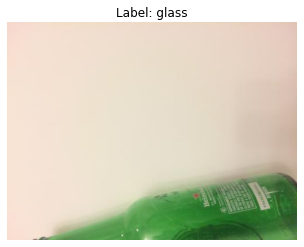

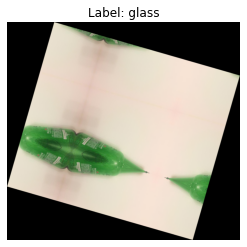

In [25]:
x, y = trashset[0]
print("Before Transform Shape:", x.shape)
plot(x, y)
xT = transform(x)
print("After Transform Shape:", xT.shape)
plot(xT, y)

Visualizing some samples

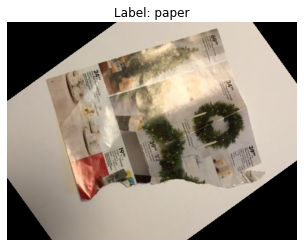

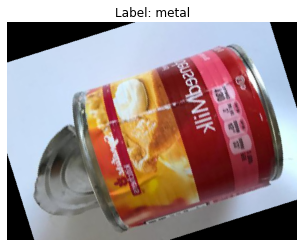

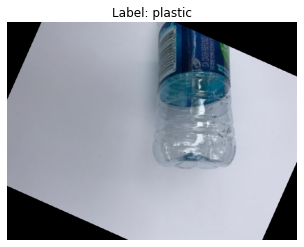

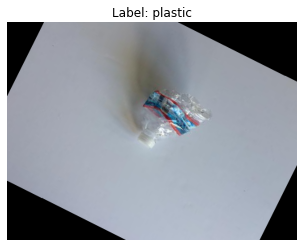

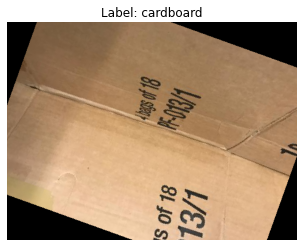

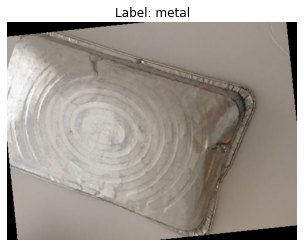

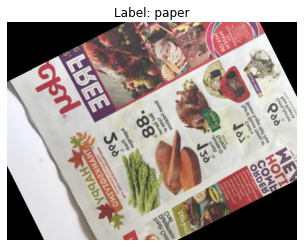

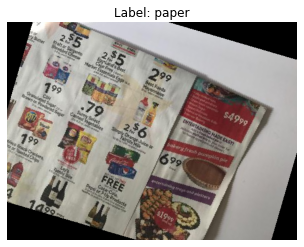

In [11]:
x,y = next(iter(train_dataloader))
transform_batch(x, transform)
for ix in range(len(x)):
    plot(x[ix], y[ix].item())

Initializing the model and optomizer

In [6]:
model = resnet18(pretrained=True)
# DenseNet
# model.classifier = torch.nn.Linear(model.classifier.in_features, len(CLASSES), bias=True)
# for elem in model.features:
#     elem.requires_grad = False
# ResNet

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(CLASSES), bias=True)
model.fc.requires_grad = True
model.device = 'cpu'
if torch.cuda.is_available():
    model.device = 'cuda'
model = model.to(model.device)
opt = Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()


total_loss = []
total_acc = []
total_learning_rate = []
total_batch_size = []
total_train_full = []
num_epochs = 0
epochs_per_run = 1

Training the model & Fine Tuning

In [37]:
opt = Adam(model.parameters(), lr=0.000001)
train_dataloader = DataLoader(train_dataset, batch_size=4)
for param in model.parameters():
    param.requires_grad = True

In [8]:
num_epochs += epochs_per_run
losses, acc = train_model(model, train_dataloader, val_dataloader, opt, epochs_per_run, transform=transform)
total_loss += losses
total_acc += acc
total_learning_rate += [opt.defaults['lr']] * len(acc)
total_batch_size += [train_dataloader.batch_size] * len(acc)
train_full = True
for param in model.parameters():
    train_full |= param.requires_grad
total_train_full += [train_full] * len(acc)

fig = plt.figure(figsize=(20,3))
plt.subplot(141)
plt.plot(total_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(142)
plt.plot(total_acc)
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.subplot(143)
plt.plot(total_batch_size)
plt.xlabel("Iteration")
plt.ylabel("Batch Size")
plt.subplot(144)
plt.plot(torch.log10(torch.tensor(total_learning_rate)))
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.show()
plt.show()

NameError: name 'epochs_per_run' is not defined

Evaluate on Test Set

In [41]:
acc = evaluate(model, test_dataloader)
print("Accuracy:", acc)

Accuracy: 0.9133858267716536


Saving the weights

In [30]:
if not os.path.isdir("models"):
    os.mkdir("models")
if not os.path.isdir("models/" + model.__class__.__name__):
    os.mkdir("models/" + model.__class__.__name__)
torch.save(model.state_dict(), "models/" + model.__class__.__name__ + "/weights.checkpoint")
torch.save(model.state_dict(), "models/" + model.__class__.__name__ + "/weights.checkpoint")
training_metadata = {"total_loss" : total_loss, "total_acc" : total_acc, "total_learning_rate" : total_learning_rate, "total_batch_size" : total_batch_size, "total_train_full" : total_train_full, "num_epochs" : num_epochs}
pickle_out = open("models/" + model.__class__.__name__ + "/training_metadata.pickle","wb")
pickle.dump(training_metadata, pickle_out)
pickle_out.close()

Loading another model

Accuracy: 0.9251968503937008


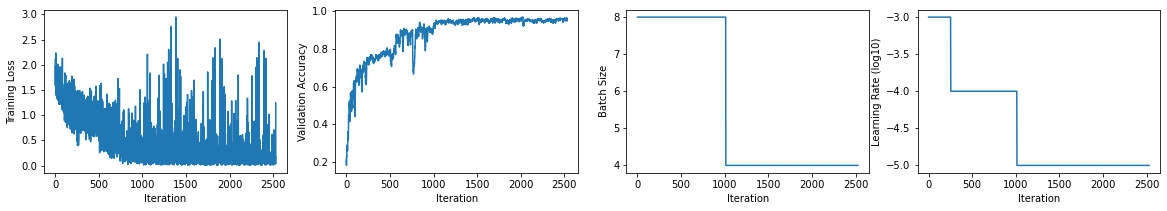

In [16]:
loadedModel = resnet18(pretrained=False)
loadedModel.fc = torch.nn.Linear(loadedModel.fc.in_features, len(CLASSES), bias=True)
loadedModel.load_state_dict(torch.load("models/resnet18/weights.checkpoint"))
loadedModel.eval()
for param in loadedModel.parameters():
    param.requires_grad = False
loadedModel.device = 'cpu'
if torch.cuda.is_available():
    loadedModel.device = 'cuda'
loadedModel.to(loadedModel.device)
acc = evaluate(loadedModel, test_dataloader)
print("Accuracy:", acc)
pickle_in = open("models/resnet18/training_metadata.pickle","rb")
loaded_obj = pickle.load(pickle_in)
pickle_in.close()
total_loss = loaded_obj["total_loss"]
total_acc = loaded_obj["total_acc"]
total_learning_rate = loaded_obj["total_learning_rate"]
total_batch_size = loaded_obj["total_batch_size"]
total_train_full = loaded_obj["total_train_full"]
num_epochs = loaded_obj["num_epochs"]

fig = plt.figure(figsize=(20,3))
plt.subplot(141)
plt.plot(total_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(142)
plt.plot(total_acc)
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.subplot(143)
plt.plot(total_batch_size)
plt.xlabel("Iteration")
plt.ylabel("Batch Size")
plt.subplot(144)
plt.plot(torch.log10(torch.tensor(total_learning_rate)))
plt.xlabel("Iteration")
plt.ylabel("Learning Rate (log10)")
plt.show()

Creating ScriptModule to export to C++


In [18]:
transcribedModel = resnet152(pretrained=False)
transcribedModel.fc = torch.nn.Linear(transcribedModel.fc.in_features, len(CLASSES), bias=True)
transcribedModel.load_state_dict(torch.load("models/resnet152/weights.checkpoint"))
transcribedModel.eval()
for param in transcribedModel.parameters():
    param.requires_grad = False

x, _ = trashset[0]
traced_script_module = torch.jit.trace(transcribedModel, x.unsqueeze(0))

transcribedModel.device = 'cpu'
traced_script_module.device = 'cpu'
traced_script_module.save("models/resnet152/transcripted_model_cpu.pt")
if torch.cuda.is_available():
    transcribedModel.device = 'cuda'
    traced_script_module.device = 'cuda'
transcribedModel.to(transcribedModel.device)
traced_script_module.to(traced_script_module.device)

if torch.cuda.is_available():
    traced_script_module.save("models/resnet152/transcripted_model_cuda.pt")

Verify Accuracy

In [ ]:
accScipted = evaluate(traced_script_module, test_dataloader)
print("Scripted Model Accuracy:", accScipted)
accExpected = evaluate(transcribedModel, test_dataloader)
print("Expected Model Accuracy:", accExpected)


Finding input sample that is correctly identified

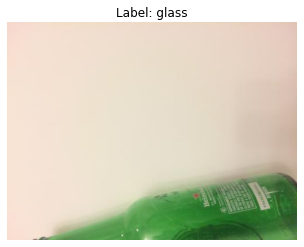

KeyboardInterrupt: 

In [17]:
x, y = trashset[0]
plot(x, y)
x = x.cuda()
predictions = traced_script_module(x.unsqueeze(0))
predictions = predictions.topk(5)
predictions = predictions.flatten()
# for pred in predictions:
print("Prediction:", CLASSES[predictions])